# Gold Price Volatility Forecasting with GARCH Model

## Import

In [36]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arch
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Define the ticker symbol for gold
gold_symbol = "GC=F"

# Create a Ticker object for gold
gold = yf.Ticker(gold_symbol)

# Get historical data for gold (you can specify the time period you want)
historical_gold_data = gold.history(period="max")

# Print the first few rows of the data (optional)
print(historical_gold_data.head())

                                 Open        High         Low       Close  \
Date                                                                        
2000-08-30 00:00:00-04:00  273.899994  273.899994  273.899994  273.899994   
2000-08-31 00:00:00-04:00  274.799988  278.299988  274.799988  278.299988   
2000-09-01 00:00:00-04:00  277.000000  277.000000  277.000000  277.000000   
2000-09-05 00:00:00-04:00  275.799988  275.799988  275.799988  275.799988   
2000-09-06 00:00:00-04:00  274.200012  274.200012  274.200012  274.200012   

                           Volume  Dividends  Stock Splits  
Date                                                        
2000-08-30 00:00:00-04:00       0        0.0           0.0  
2000-08-31 00:00:00-04:00       0        0.0           0.0  
2000-09-01 00:00:00-04:00       0        0.0           0.0  
2000-09-05 00:00:00-04:00       2        0.0           0.0  
2000-09-06 00:00:00-04:00       0        0.0           0.0  


In [3]:
# Save the data to a CSV file
csv_file_name = "gold_historical_data.csv"
historical_gold_data.to_csv(csv_file_name)

# Confirm that the data has been saved
print(f"Data saved to {csv_file_name}")

Data saved to gold_historical_data.csv


In [4]:
# Load the data from the CSV file
gold = pd.read_csv(csv_file_name)
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5772 non-null   object 
 1   Open          5772 non-null   float64
 2   High          5772 non-null   float64
 3   Low           5772 non-null   float64
 4   Close         5772 non-null   float64
 5   Volume        5772 non-null   int64  
 6   Dividends     5772 non-null   float64
 7   Stock Splits  5772 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 360.9+ KB


We can drop the "Dividends" and "Stock Splits" columns from our DataFrame.These columns often contain information related to corporate actions and dividends paid to shareholders, which may not be necessary for our volatility forecasting project.

## Prepare Data

In [5]:
gold.drop(columns=["Dividends", "Stock Splits"], inplace=True) # Drop "Dividends", "Stock Splits" columns
gold['Date'] = pd.to_datetime(gold['Date'], utc=True) # Change dtype
 # Set as the index
gold.set_index('Date', inplace=True) 
# Resample the data to daily frequency (D)
gold.resample('D').ffill()

,Open,High,Low,Close,Volume
Date,,,,,
2000-08-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2000-08-31 00:00:00+00:00,273.899994,273.899994,273.899994,273.899994,0.0
2000-09-01 00:00:00+00:00,274.799988,278.299988,274.799988,278.299988,0.0
2000-09-02 00:00:00+00:00,277.000000,277.000000,277.000000,277.000000,0.0
2000-09-03 00:00:00+00:00,277.000000,277.000000,277.000000,277.000000,0.0
...,...,...,...,...,...
2023-08-28 00:00:00+00:00,1919.800049,1919.800049,1911.099976,1911.099976,195.0
2023-08-29 00:00:00+00:00,1915.500000,1921.500000,1915.500000,1917.900024,99.0
2023-08-30 00:00:00+00:00,1917.900024,1936.500000,1916.900024,1936.500000,1674.0


In [6]:
# Remove the time part from the index
gold.index = gold.index.strftime('%Y-%m-%d')
# Sort the DataFrame in descending order by index (Date)
gold.sort_index(ascending=True,inplace=True)

## Explore

In [7]:
gold.describe()

,Open,High,Low,Close,Volume
count,5772.000000,5772.000000,5772.000000,5772.000000,5772.000000
mean,1096.102651,1101.571085,1090.310049,1096.012872,4298.497748
std,524.501405,527.460859,521.343366,524.445787,24452.295576
min,255.000000,256.100006,255.000000,255.100006,0.000000
25%,598.075012,604.000000,597.299988,598.075012,20.000000
50%,1214.599976,1221.099976,1208.199951,1214.800049,103.000000
75%,1501.500000,1507.624969,1491.625000,1500.625000,394.000000
max,2053.600098,2072.000000,2040.000000,2051.500000,386334.000000


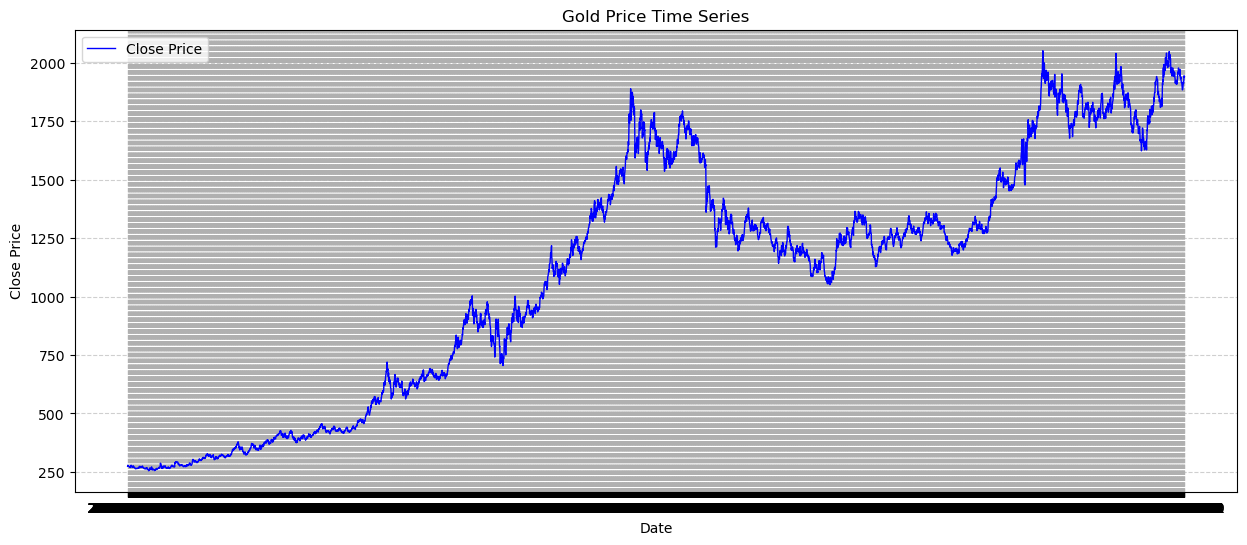

In [8]:
# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the 'Close' price
plt.plot(gold.index, gold['Close'], label='Close Price', color='b', linewidth=1)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Gold Price Time Series')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend()

# Show the plot
plt.show()

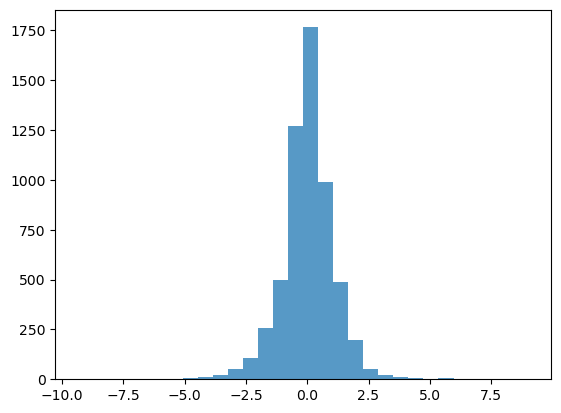

In [9]:
gold["Return"] = gold["Close"].pct_change()*100
gold.dropna(subset=["Return"], inplace=True)
plt.hist(gold['Return'], bins=30, alpha=0.75);

In [11]:
gold.head()

,Open,High,Low,Close,Volume,Return
Date,,,,,,
2000-08-31,274.799988,278.299988,274.799988,278.299988,0,1.606424
2000-09-01,277.000000,277.000000,277.000000,277.000000,0,-0.467117
2000-09-05,275.799988,275.799988,275.799988,275.799988,2,-0.433217
2000-09-06,274.200012,274.200012,274.200012,274.200012,0,-0.580122
2000-09-07,274.000000,274.000000,274.000000,274.000000,125,-0.072944


In [12]:
# Calculate daily volatility
gold_daily_volatility = gold['Close'].std()

# Print the type and value of daily volatility
print("Gold Daily Volatility type:", type(gold_daily_volatility))
print("Gold Daily Volatility:", gold_daily_volatility)

Gold Daily Volatility type: <class 'float'>
Gold Daily Volatility: 524.3795345625099


In [13]:
# Calculate the annual volatility (assuming 252 trading days in a year)
gold_annual_volatility = gold_daily_volatility * (252 ** 0.5)

# Print the type and value of gold_annual_volatility
print("Gold_annual_volatility type:", type(gold_annual_volatility))
print("Gold Annual Volatility:", gold_annual_volatility)

Gold_annual_volatility type: <class 'float'>
Gold Annual Volatility: 8324.267046385203


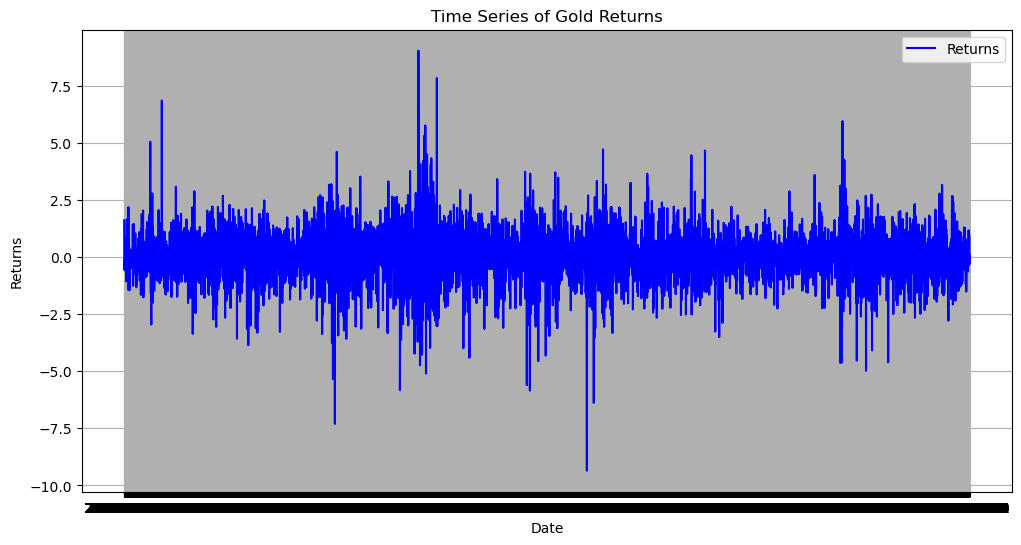

In [14]:
# Create a time series line plot
plt.figure(figsize=(12, 6))
plt.plot(gold.index, gold['Return'], label='Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Time Series of Gold Returns')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Calculate rolling volatility with a 50-day window
gold_rolling_50d_volatility = gold["Return"].rolling(window=50).std().dropna()

# Print the type, shape, and the first few rows of the rolling volatility
print("rolling_50d_volatility type:", type(gold_rolling_50d_volatility))
print("rolling_50d_volatility shape:", gold_rolling_50d_volatility.shape)
print(gold_rolling_50d_volatility.head())

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (5722,)
Date
2000-11-09    0.674911
2000-11-10    0.633234
2000-11-13    0.631015
2000-11-14    0.630634
2000-11-15    0.626799
Name: Return, dtype: float64


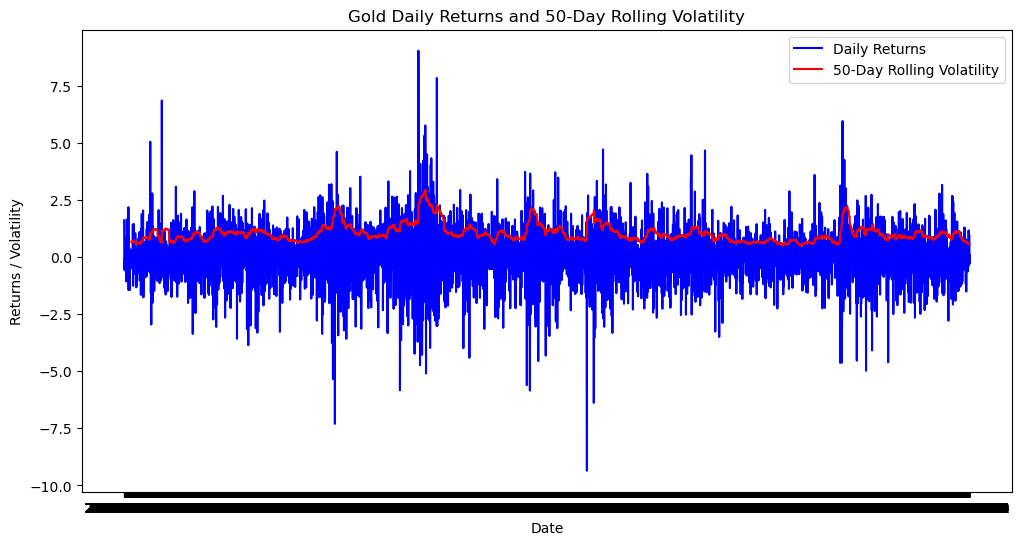

In [19]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot daily returns
ax.plot(gold.index, gold["Return"], label="Daily Returns", color="b")

# Plot 50-day rolling volatility
ax.plot(gold_rolling_50d_volatility.index, gold_rolling_50d_volatility, label="50-Day Rolling Volatility", color="r")

# Add labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Returns / Volatility")
ax.set_title("Gold Daily Returns and 50-Day Rolling Volatility")

# Add a legend
ax.legend()

# Show the plot
plt.show()

Here we can see that volatility goes up when the returns change up or down. 

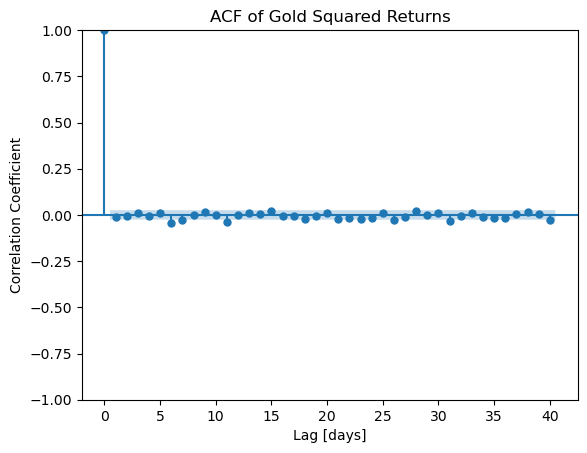

In [21]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Create ACF plot
acf_plot = sm.graphics.tsa.plot_acf(gold['Return'], lags=40)

# Customize plot labels and title
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.title('ACF of Gold Returns')

# Show the plot
plt.show()

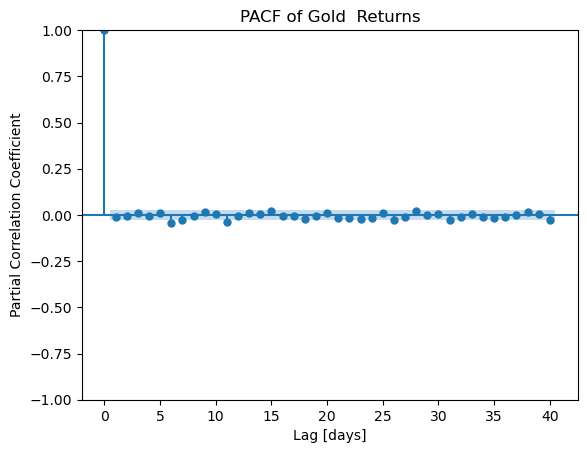

In [22]:
# Create PACF plot
pacf_plot = sm.graphics.tsa.plot_pacf(gold['Return'], lags=40)

# Customize plot labels and title
plt.xlabel('Lag [days]')
plt.ylabel('Partial Correlation Coefficient')
plt.title('PACF of Gold  Returns')

# Show the plot
plt.show()


In [24]:
gold_return = gold["Return"]

Both the ACF and PACF graph show one lag is enough to build the model.
Normally, at this point in the model building process, we would split our data into training and test sets, and then set a baseline. Not this time. This is because our model's input and its output are two different measurements. We'll use **returns** to train our model, but we want it to predict **volatility**. If we created a test set, it wouldn't give us the "true values" that we'd need to assess our model's performance.

In [26]:
# Calculate the number of rows for the training set (80%)
train_size = int(0.8 * len(gold_return))

# Create the training set by slicing the DataFrame
gold_train = gold_return.iloc[:train_size]

# Check the shape of the training set
print("Shape of gold_train:", gold_train.shape)

Shape of gold_train: (4616,)


## Build Model

In [29]:
# Build and train model
model = arch_model(
    gold_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6697.50
Distribution:                  Normal   AIC:                           13403.0
Method:            Maximum Likelihood   BIC:                           13428.7
                                        No. Observations:                 4616
Date:                Sat, Sep 02 2023   Df Residuals:                     4615
Time:                        12:53:15   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0363  1.461e-02      2.486  1.292e-02 [7.683e-03,6.494e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.1561e-03  4.188e-03      2.186  2.879e-02 [9.479e-04,1.736e-02]
alpha[1]       0.0324  8.941e-03      3.624  2.896e-04 [1.488e-02,4.993e-02]
beta[1]        0.9602  1.100e-02     87.282      0.000     [  0.939,  0.982]
============================================================================

Covariance estimator: robust
"""

In [30]:
model.aic

13402.996802649077

In [31]:
model.bic

13428.74593788183

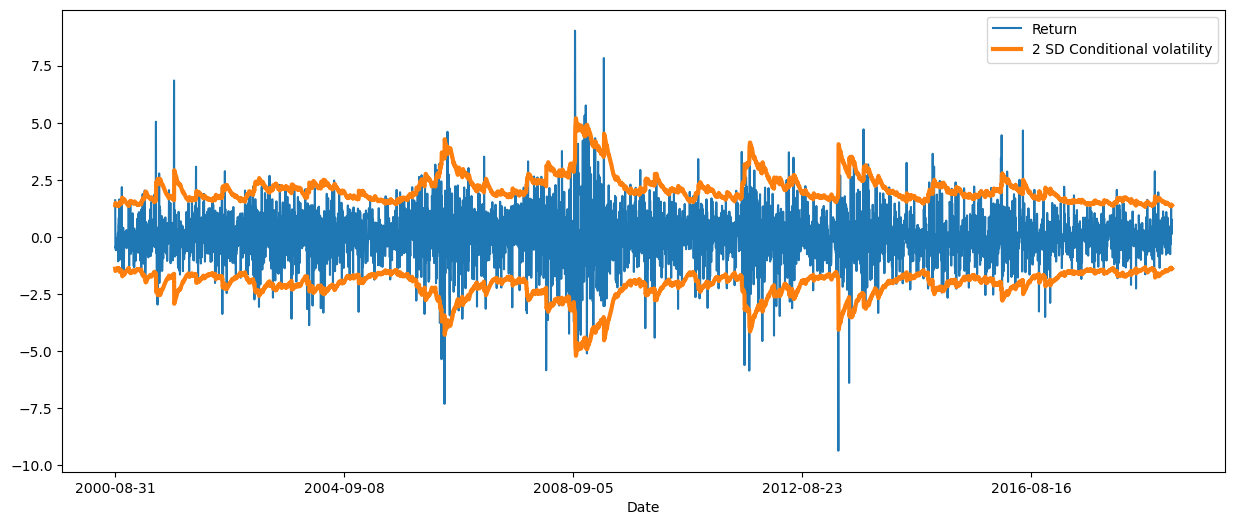

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
gold_train.plot(ax=ax)

# Plot conditional volatility * 2
(2*model.conditional_volatility).plot(
    ax=ax, color="C1",label="2 SD Conditional volatility",linewidth=3
)

# Plot conditional volatility * -2

(-2*model.conditional_volatility.rename("")).plot(
    ax=ax, color="C1",linewidth=3
)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

Visually, our model looks pretty good, but we should examine residuals, just to make sure. In the case of GARCH models, we need to look at the standardized residuals. 

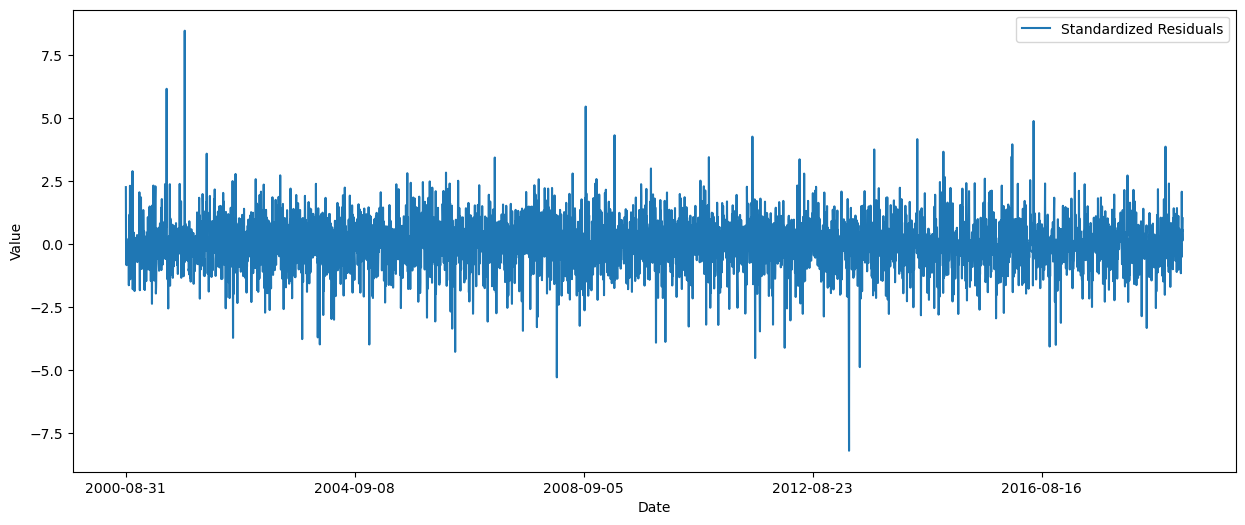

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Value")

# Add legend
plt.legend();

These residuals look good: they have a consistent mean and spread over time. Let's check their normality using a histogram. 

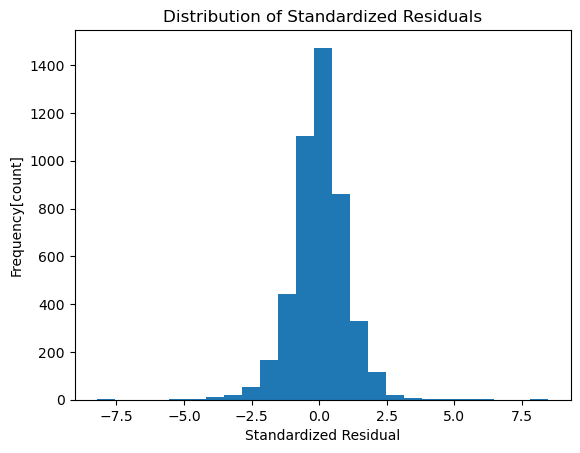

In [34]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins=25);

# Add axis labels
plt.xlabel("Standardized Residual")
plt.ylabel("Frequency[count]")

# Add title
plt.title("Distribution of Standardized Residuals");

We got a good normal distribution, which is good!
Our last visualization will the ACF of standardized residuals. 

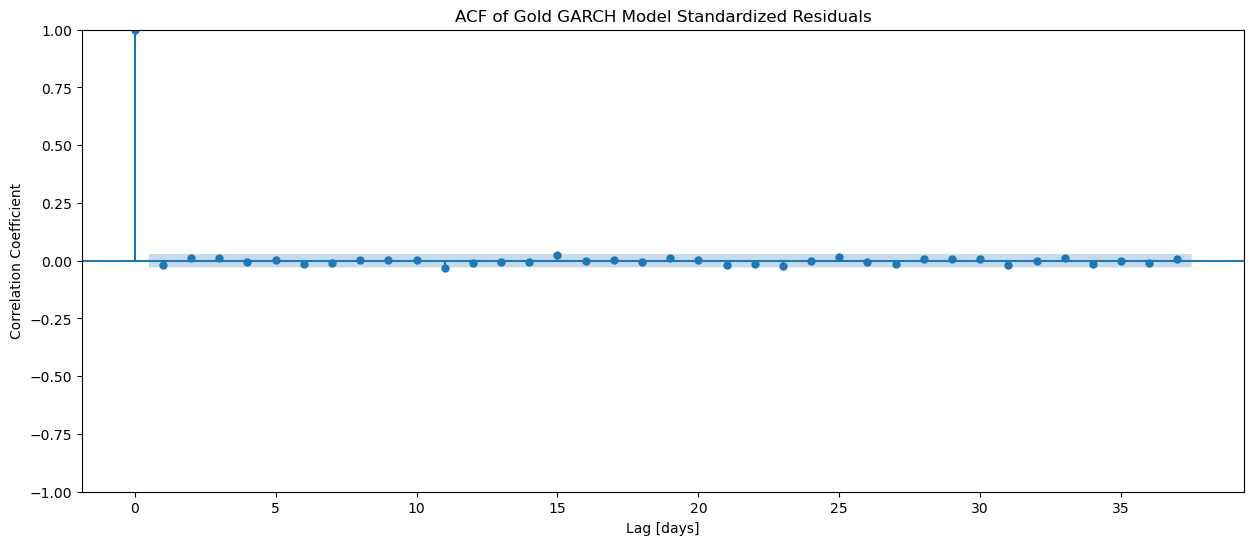

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid,ax=ax);

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("ACF of Gold GARCH Model Standardized Residuals");

Excellent! Looks like this model is ready for a final evaluation.

In [41]:
gold_train.tail(1)

Date
2019-01-31    0.748143
Name: Return, dtype: float64

In [42]:
one_day_forecast = model.forecast(horizon=1,reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast.iloc[0,0]**0.5

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


0.6989092523838079

There are two things we need to keep in mind here. First, our `model` forecast shows the predicted **variance**, not the **standard deviation** / **volatility**. So we'll need to take the square root of the value. Second, the prediction is in the form of a DataFrame. It has a DatetimeIndex, and the date is the last day for which we have training data. The `"h.1"` column stands for "horizon 1", that is, our model's prediction for the following day. We'll have to keep all this in mind when we reformat this prediction to serve to the end user of our application.

In [43]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(gold_return) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = gold_return.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train,p=1,q=1,rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1,reindex=False).variance.iloc[0,0]**0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=gold_return.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (1154,)


Date
2019-02-04    0.692516
2019-02-05    0.686102
2019-02-06    0.678533
2019-02-07    0.675030
2019-02-08    0.667709
dtype: float64

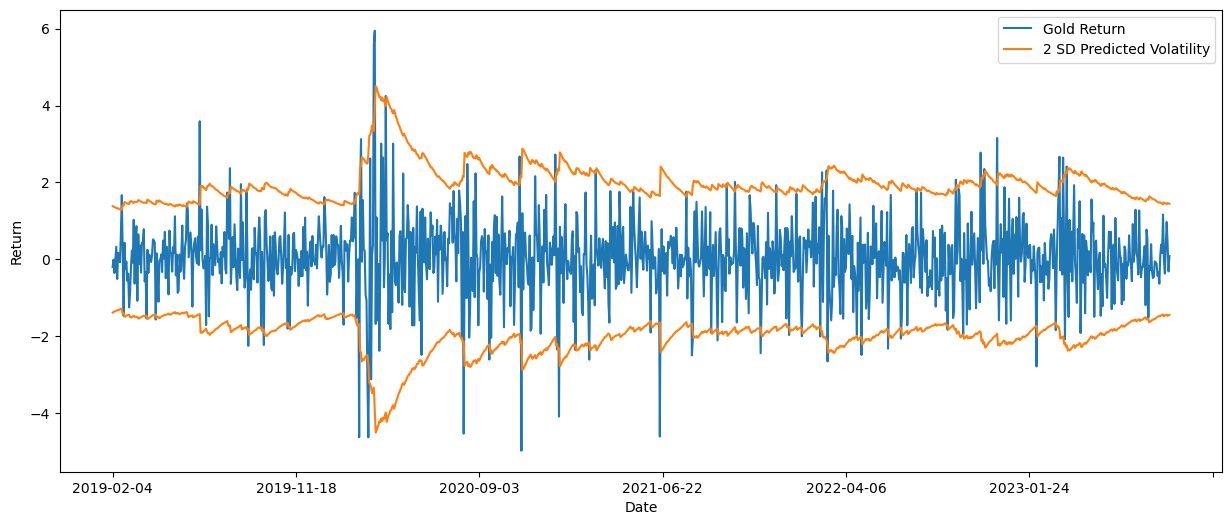

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
gold_return.tail(test_size).plot(ax=ax, label="Gold Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

This looks pretty good. Our volatility predictions seem to follow the changes in returns over time. This is especially clear in the high-volatility period in winter 2019.


# Communicate Results

In [49]:
def clean_prediction(prediction):
    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from an `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is a date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = pd.Timestamp(prediction.index[0]) + pd.DateOffset(days=1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])
    
    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten()**0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index=prediction_index)

    # Return Series as a dictionary
    return prediction_formatted.to_dict()

In [51]:
# Example usage
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)
prediction_formatted

{'2023-09-01T00:00:00': 0.722493693854281,
 '2023-09-04T00:00:00': 0.7270339121259957,
 '2023-09-05T00:00:00': 0.7315004541197309,
 '2023-09-06T00:00:00': 0.735895118852947,
 '2023-09-07T00:00:00': 0.7402196367278909,
 '2023-09-08T00:00:00': 0.7444756732543961,
 '2023-09-11T00:00:00': 0.748664832512326,
 '2023-09-12T00:00:00': 0.7527886603757357,
 '2023-09-13T00:00:00': 0.7568486475186438,
 '2023-09-14T00:00:00': 0.7608462322203637}

# Project Summary: Gold Price Volatility Forecasting with GARCH Model

## Import and Data Collection:
- The project focuses on forecasting gold price volatility using a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model.
- Data is obtained using the `yfinance` library for historical gold price information, and the data is stored in a CSV file for further analysis.

## Data Preparation:
- The project drops unnecessary columns like "Dividends" and "Stock Splits" from the dataset.
- The date column is converted to a datetime format, and the date becomes the index.
- Data is resampled to daily frequency (D) and sorted in ascending order by date.

## Exploratory Data Analysis:
- Descriptive statistics are calculated for the gold price data.
- A time series plot of the daily closing prices of gold is created, showing the trend over time.
- Daily returns are calculated and visualized with a histogram.
- Daily volatility and annualized volatility are calculated.

## Time Series Analysis:
- A time series plot of gold returns is created.
- Rolling volatility with a 50-day window is calculated and plotted.
- AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) plots are generated to determine the lag for the GARCH model.

## Model Building:
- The GARCH(1,1) model is built using the `arch` library, and it is trained on the gold return data.

## Model Evaluation:
- Model summary statistics, AIC, and BIC are evaluated to assess the model's fit.
- Residual analysis is performed by plotting standardized residuals and checking for normality.

## Model Forecasting:
- One-day ahead volatility forecasts are generated using the trained GARCH model.
- The forecasts are converted to JSON format for future use.

## Walk Forward Validation:
- Walk forward validation is performed to assess model performance on a rolling basis.
- Volatility predictions are made for each test data point and compared to actual returns.

## Results Communication:
- The `clean_prediction` function is defined to reformat model predictions into JSON format.
- An example usage of the function is provided to demonstrate how to format and access model predictions.

## Overall Insights:
- The GARCH model shows promise in forecasting gold price volatility, with volatility closely tracking changes in returns.
- The model can be used for short-term volatility forecasting and risk management in gold investments.

This project provides a comprehensive analysis and forecasting solution for gold price volatility, making it a valuable tool for investors and analysts in the financial sector.